# Hateful Speech Detection With Classic ML and Bert Models

By: Aayushi Shah, Alex Shu,Jacob Sasser

### Description
In this notebook, We aim to explore various methods for detecting hateful speech within the dataset.
   
1. TF-IDF with Linear Regression model
2. Bert model with native Pytorch

In [1]:
import sys

!{sys.executable} -m pip install wordcloud nltk evaluate shap


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   -------------------- ------------------- 235.5/456.1 kB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.7 MB 30.4 MB/s eta 0:00:01
   ------------------------------------- -- 2.5/2.7 MB 31.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 28.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 1.7/28.1 MB 35.5 MB/s eta 0:00:01
   ---- ----------------------------------- 3.3/28.1 MB 34.6 MB/s eta 0:00:01
   ------ --------------------------------- 4.8/28.1 MB 33.9 MB/s eta 0:00:01
   --------- ------------------------------ 6.4/28.1 MB 34.2 MB/s eta 0:00:01
   -----------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# Load the Data

In [5]:
data_full = pd.read_csv('./dataset/HateSpeechDataset.csv')

num_rows, num_cols = data_full.shape
print(f'Rows: {num_rows},  columns: {num_cols}')

data_full.sample(5)

Rows: 440906,  columns: 3


,Content,Label,Content_int
376160,park,0,"[146715, 5205, 146714]"
358829,please look at the original in page of this li...,0,"[146715, 389, 618, 236, 3, 2256, 94, 1830, 1, ..."
291652,conservation do whatever really need to protec...,0,"[146715, 1601, 340, 220, 438, 188, 7, 4232, 15..."
148478,special characters are indeed the and on top o...,0,"[146715, 5314, 6232, 154, 2042, 3, 111, 9, 316..."
333949,there are any number of wiki news articles whi...,0,"[146715, 405, 154, 232, 1422, 1, 7996, 1329, 5..."


In [6]:
data_full = data_full[data_full["Label"] != "Label"]

In [7]:
label_counts = data_full['Label'].value_counts().sort_index()
print(label_counts)

Label
0    361594
1     79305
Name: count, dtype: int64


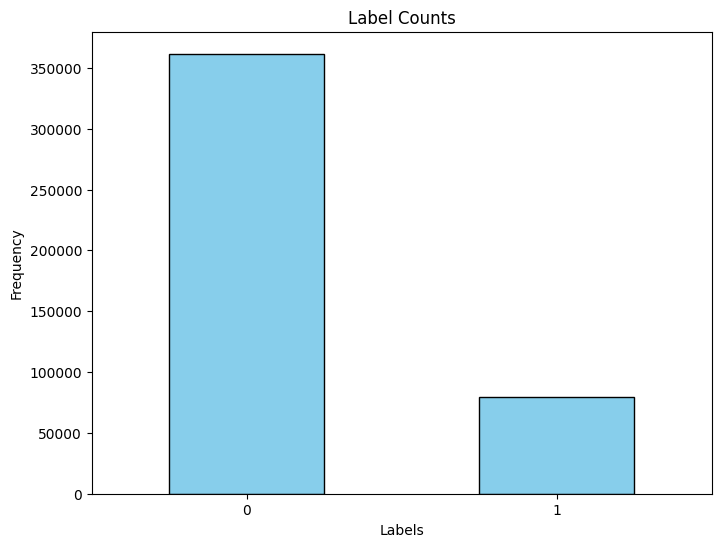

In [8]:
# Plotting with matplotlib for the lable counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Label Counts')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [9]:
#Change the Label from string to integer
data_full['Label'] = pd.to_numeric(data_full['Label'], errors='coerce')

In [10]:
#The dataset is quite big so we take just 4000 examples of each class
df1 = data_full.query('Label == 0').sample(10000)
df2 = data_full.query('Label == 1').sample(10000)
data = pd.concat([df1, df2], ignore_index=True)

data.shape

(20000, 3)

# Data Exploration  
Let's take a look on the most frequent words for each class

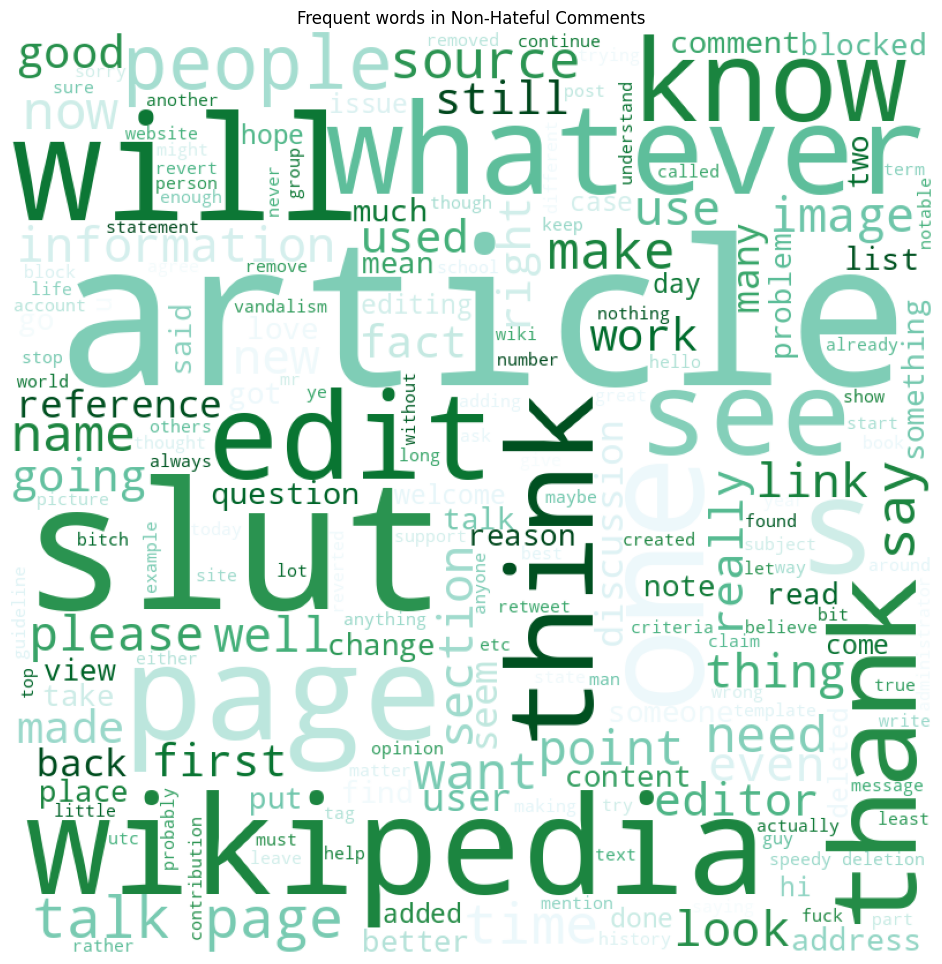

In [11]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

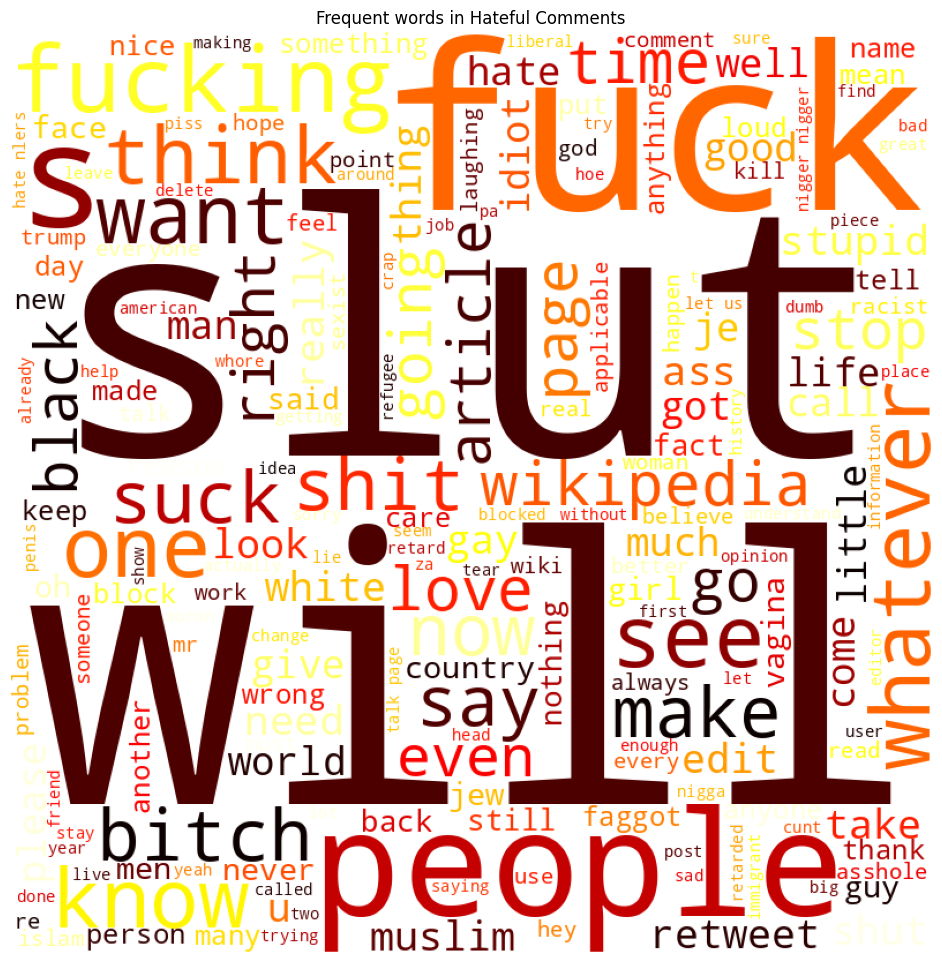

In [12]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

# TF-IDF with Linear Regression model  
  
This approach can be considered as baseline.  
Firstly, we need clean and prepare text: clean, remove stopwords, apply lemmatization OR stemming. By default I choose stemming.  
Then convert text to TF-IDF vector and use it as a feature for simple classification model LogisticRegression

In [13]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FTGMSF22\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
data_tfidf = data.copy()

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FTGMSF22\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)
    
    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)            
            res.append(prepared_word)
    return ' '.join(res)

In [17]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FTGMSF22\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FTGMSF22\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
from nltk.tokenize import word_tokenize
text = "Hello, this is a test sentence."
tokens = word_tokenize(text)
print(tokens)

['Hello', ',', 'this', 'is', 'a', 'test', 'sentence', '.']


In [19]:
data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning)

In [20]:
train, test = train_test_split(data_tfidf, test_size=0.3, stratify=data['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [21]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [22]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [23]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3000
           1       0.80      0.81      0.80      3000

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,2379,621
Actual: Hateful,563,2437


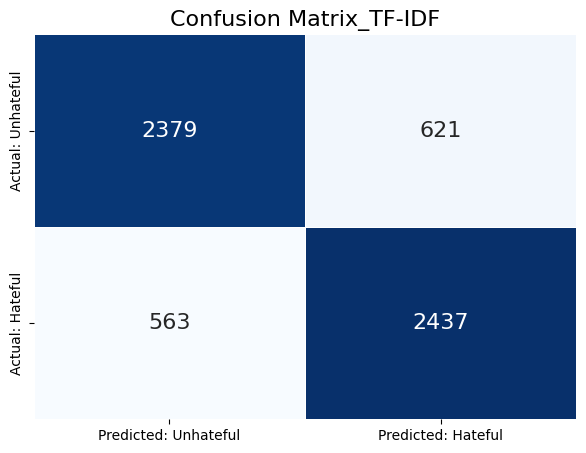

In [24]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_tf_idf)

# Create a DataFrame for better readability
cm_df = pd.DataFrame(cm, 
                     columns=["Predicted: Unhateful", "Predicted: Hateful"], 
                     index=["Actual: Unhateful", "Actual: Hateful"])

# Plot the colorful confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion Matrix_TF-IDF', fontsize=16)
plt.show()

# Bert model with native Pytorch  
  
Now I want to train Bert model with classification head with native Pytorch.   


In [25]:
train, validation = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)

In [26]:
class HateSpeechDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data.iloc[idx]
        text = example["Content"]
        label = example["Label"]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float),
        }


In [27]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def custom_collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.float)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


dataset_train = HateSpeechDataset(train, tokenizer)
dataset_val = HateSpeechDataset(validation, tokenizer)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=False, collate_fn=custom_collate_fn)
for batch in dataloader_train:
    print(batch.keys())
    break

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [28]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)
        
        # Fine-tune the last two layers of BERT
        for n, p in self.bert.named_parameters():
            if "layer.10" in n or "layer.11" in n or "pooler" in n:
                p.requires_grad = True
            else:
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        x = self.relu(self.linear1(bert_output))
        x = self.dropout(x)
        return self.linear2(x)

In [29]:
model = BERTClassifier()


## Train with native Pytorch

In [30]:
from transformers import get_scheduler
epochs = 10
model = BERTClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Scheduler for dynamic learning rate adjustment
num_training_steps = len(dataloader_train) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
patience = 2
patience_counter = 0

train_losses, val_losses = [], []

for epoch_i in range(epochs):
    model.train()
    total_train_loss = 0
    y_true_train, y_pred_train = [], []
    
    for batch in tqdm(dataloader_train, desc=f"Training Epoch {epoch_i+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # Updated key to "labels"
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        preds = torch.sigmoid(outputs).detach().cpu().numpy() >= 0.5
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds)
    
    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(y_true_train, y_pred_train)

    # Validation
    model.eval()
    total_val_loss = 0
    y_true_val, y_pred_val = [], []
    
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # Updated key to "labels"
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), labels)
            total_val_loss += loss.item()
            
            preds = torch.sigmoid(outputs).detach().cpu().numpy() >= 0.5
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds)
    
    avg_val_loss = total_val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch_i+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_accuracy:.4f}, Val Acc={val_accuracy:.4f}")



Training Epoch 1:   0%|          | 0/219 [00:00<?, ?it/s]C:\Users\FTGMSF22\AppData\Local\anaconda3\envs\pytoch-tensor-cuda118\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training Epoch 1: 100%|██████████| 219/219 [02:12<00:00,  1.65it/s]


Epoch 1: Train Loss=0.5175, Val Loss=0.4405, Train Acc=0.7459, Val Acc=0.7990


Training Epoch 2: 100%|██████████| 219/219 [02:09<00:00,  1.69it/s]


Epoch 2: Train Loss=0.4284, Val Loss=0.4225, Train Acc=0.8022, Val Acc=0.8060


Training Epoch 3: 100%|██████████| 219/219 [02:09<00:00,  1.69it/s]


Epoch 3: Train Loss=0.4004, Val Loss=0.4162, Train Acc=0.8193, Val Acc=0.8105


Training Epoch 4: 100%|██████████| 219/219 [02:09<00:00,  1.69it/s]


Epoch 4: Train Loss=0.3807, Val Loss=0.4031, Train Acc=0.8291, Val Acc=0.8172


Training Epoch 5: 100%|██████████| 219/219 [02:10<00:00,  1.67it/s]


Epoch 5: Train Loss=0.3694, Val Loss=0.4031, Train Acc=0.8357, Val Acc=0.8183


Training Epoch 6: 100%|██████████| 219/219 [02:09<00:00,  1.69it/s]


Early stopping triggered.


In [31]:
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
# Prepare for evaluation
y_true_bert = []  # True labels
y_pred_bert = []  # Predicted labels

model.eval()
with torch.no_grad():
    for batch in dataloader_val:  # Replace with dataloader_test if testing on separate data
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).detach().cpu().numpy() >= 0.5
        y_true_bert.extend(labels.cpu().numpy())
        y_pred_bert.extend(preds)

# Convert predictions and true labels to arrays
y_true_bert = np.array(y_true_bert)
y_pred_bert = np.array(y_pred_bert).astype(int)

# Compute and print metrics
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))

# Display confusion matrix
conf_matrix = confusion_matrix(y_true_bert, y_pred_bert)
display(pd.DataFrame(
    {"Predicted: Unhateful": conf_matrix[:, 0], 
     "Predicted: Hateful": conf_matrix[:, 1]},
    index=['Actual: Unhateful', 'Actual: Hateful']
))

Test accuracy: 0.82

Classification report: 
               precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      3000
         1.0       0.80      0.85      0.82      3000

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,2363,637
Actual: Hateful,460,2540


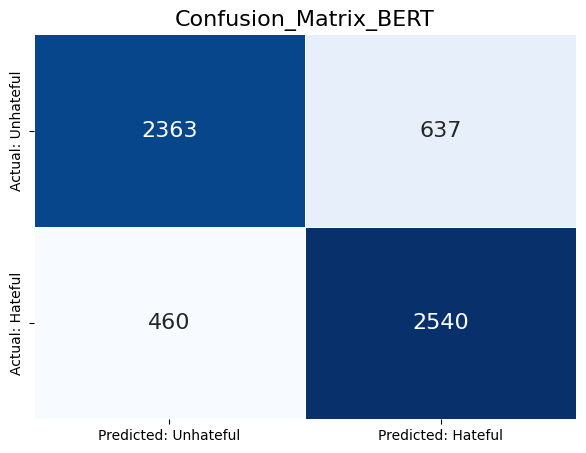

In [32]:
# Generate the confusion matrix
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

# Create a DataFrame for better readability
cm_df_bert = pd.DataFrame(cm_bert, 
                     columns=["Predicted: Unhateful", "Predicted: Hateful"], 
                     index=["Actual: Unhateful", "Actual: Hateful"])

# Plot the colorful confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_df_bert, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16}, linewidths=0.5)
plt.title('Confusion_Matrix_BERT', fontsize=16)
plt.show()

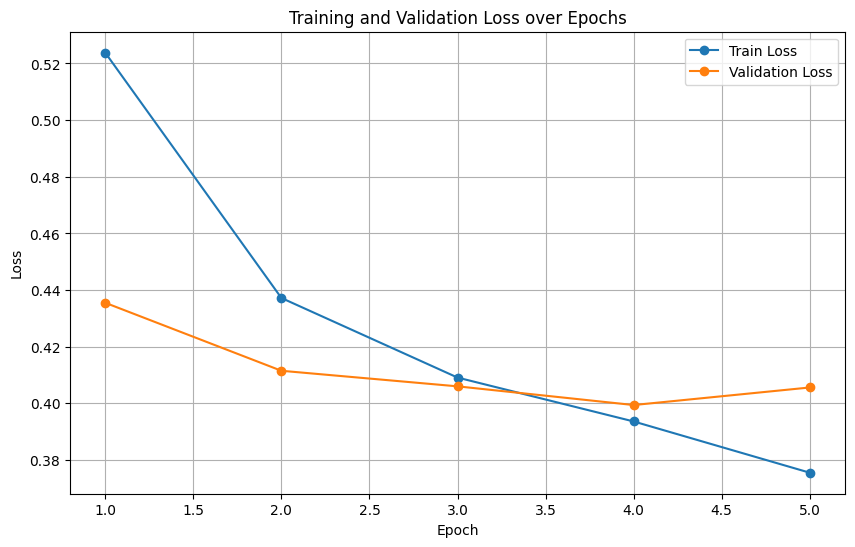

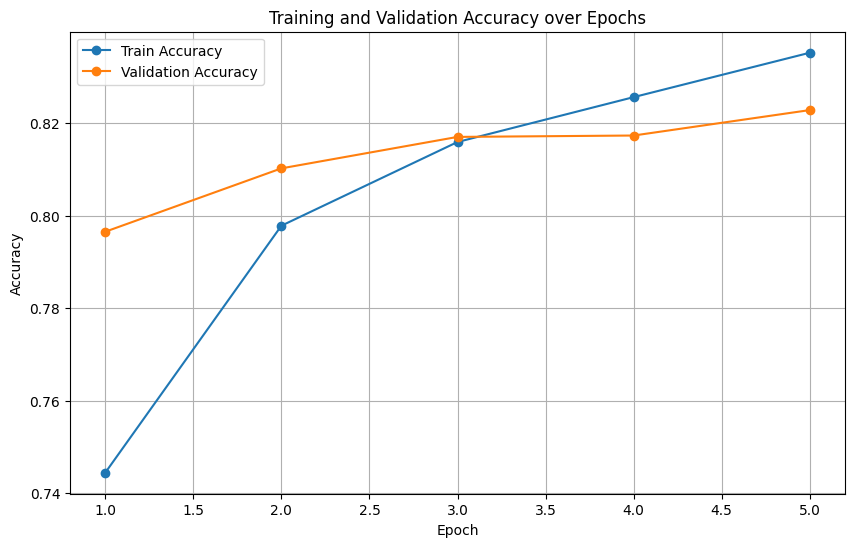

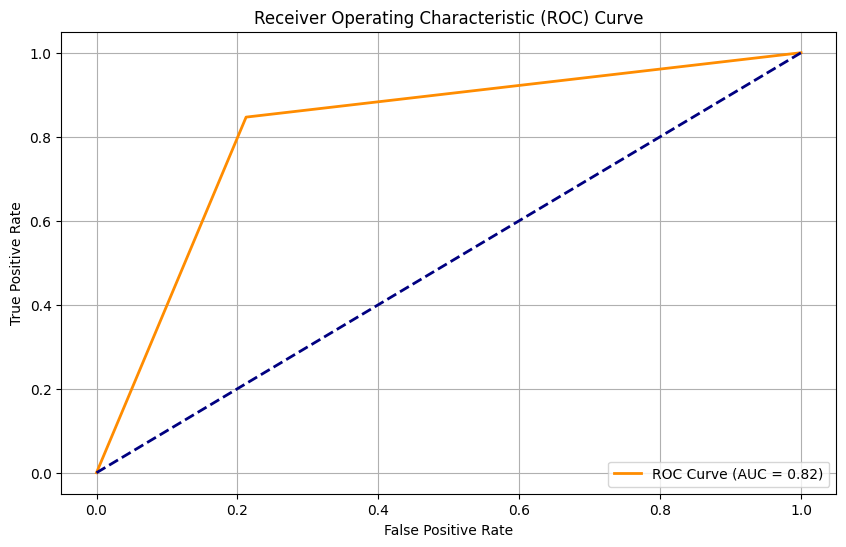

In [33]:
# Data extracted from the training logs
epochs = [1, 2, 3, 4, 5]
train_losses = [0.5238, 0.4372, 0.4091, 0.3936, 0.3755]
val_losses = [0.4355, 0.4115, 0.4060, 0.3994, 0.4056]
train_accuracies = [0.7444, 0.7978, 0.8159, 0.8256, 0.8352]
val_accuracies = [0.7965, 0.8102, 0.8170, 0.8173, 0.8228]

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve, auc

# Ensure probabilities are available for ROC curve
y_pred_probs = np.array(y_pred_bert).astype(float)  # Replace with probabilities if available

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_bert, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [34]:
import shap

class ModelWrapper:
    def __init__(self, model, tokenizer, max_length=128):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, texts):
        # Convert SHAP-masked tokens to strings
        texts = [" ".join(t) for t in texts]
        # Tokenize input texts
        encoded_inputs = self.tokenizer(
            texts,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        # Move inputs to the device
        input_ids = encoded_inputs["input_ids"].to(device)
        attention_mask = encoded_inputs["attention_mask"].to(device)


        # Run the model
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask)

        # Extract logits
        if hasattr(outputs, "logits"):
            logits = outputs.logits
        elif isinstance(outputs, torch.Tensor):
            logits = outputs
        else:
            raise ValueError(f"[ERROR] Unexpected model output type: {type(outputs)}")
        return logits.cpu().numpy()


# Initialize wrapper
wrapped_model = ModelWrapper(model, tokenizer)

# Define SHAP masker and explainer
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(wrapped_model, masker)

sample_text = validation["Content"].tolist()[0]

try:
    shap_values = explainer([sample_text])
    print("[DEBUG] SHAP values generated successfully.")
    shap.plots.text(shap_values[0])
except Exception as e:
    print("[DEBUG] Exception occurred during SHAP explanation:", e)


[DEBUG] SHAP values generated successfully.


### Predict on raw text

In [35]:
review_texts = ["I will travel to New Jersey tomorrow.",
               "This is the worst restaurent.",
               "It is a beatiful day."]

In [36]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

encoded_reviews = tokenizer.batch_encode_plus(
    review_texts,
    padding=True,
    truncation=True,
    max_length=128,  # Adjust this based on the model's input size
    return_tensors="pt"  # Output tensors in PyTorch format
)

In [37]:
# Extract `input_ids` and `attention_mask`
input_ids = encoded_reviews["input_ids"]
attention_mask = encoded_reviews["attention_mask"]

In [38]:
model.eval()  # Set the model to evaluation mode
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Get model output
with torch.no_grad():
    outputs = model(input_ids, attention_mask)

# Apply sigmoid to get probabilities
probs = torch.sigmoid(outputs).cpu().numpy().reshape(-1)

# Classify using threshold (e.g., 0.5)
predictions = (probs >= 0.5).astype(int)

# Map results
results = ["Hateful" if pred == 1 else "Non-hateful" for pred in predictions]


In [39]:
# Print results
for review, result in zip(review_texts, results):
    print(f"Review: {review} --> Classification: {result}")

Review: I will travel to New Jersey tomorrow. --> Classification: Non-hateful
Review: This is the worst restaurent. --> Classification: Hateful
Review: It is a beatiful day. --> Classification: Non-hateful


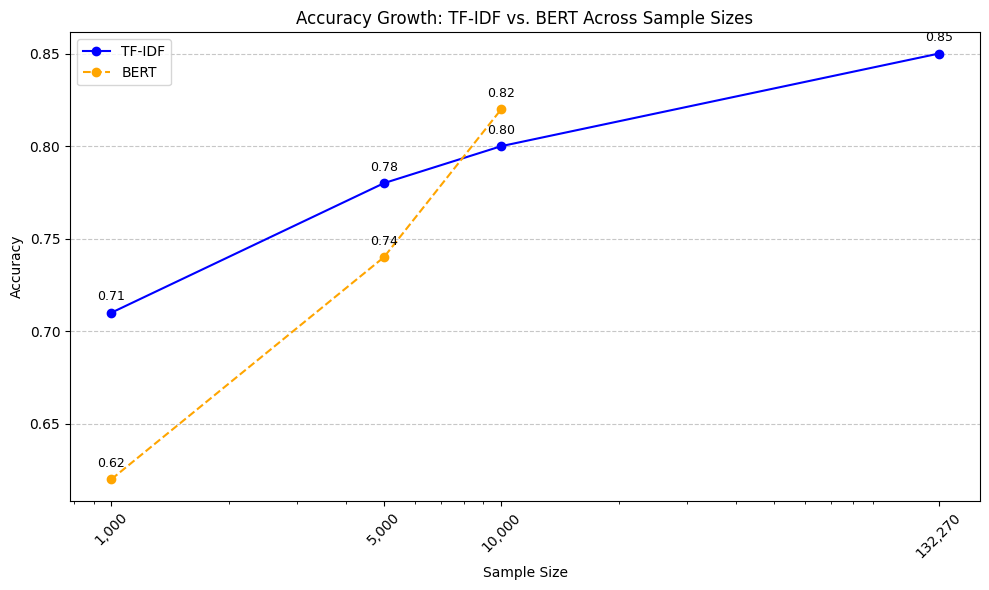

In [40]:
# I got these manually from above by changing the sample size in df1, df2, the last sample of 132270 is so there was even distribution of labels
sample_sizes = [1000, 5000, 10000, 132270]
tfidf_accuracies = [0.71, 0.78, 0.80, 0.85]
bert_accuracies = [0.62, 0.74, 0.82]
bert_sample_sizes = sample_sizes[:len(bert_accuracies)]
# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, tfidf_accuracies, marker='o', label="TF-IDF", linestyle='-', color='blue')
plt.plot(bert_sample_sizes, bert_accuracies, marker='o', label="BERT", linestyle='--', color='orange')

# Add labels, title, and legend
plt.title("Accuracy Growth: TF-IDF vs. BERT Across Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.xscale("log")  # Use log scale for better visualization of sample size differences
plt.xticks(sample_sizes, [f"{size:,}" for size in sample_sizes], rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
# Annotate the points
for size, acc in zip(sample_sizes, tfidf_accuracies):
    plt.text(size, acc + 0.005, f"{acc:.2f}", ha="center", va="bottom", fontsize=9)
for size, acc in zip(bert_sample_sizes, bert_accuracies):
    plt.text(size, acc + 0.005, f"{acc:.2f}", ha="center", va="bottom", fontsize=9)

# Show the plot
plt.tight_layout()
plt.savefig("sample_size.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()